In [ ]:
# Data from https://download.pytorch.org/tutorial/hymenoptera_data.zip

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy

plt.ion()

In [2]:
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
}

data_dir = 'data/hymenoptera_data'
image_datasets = {
    x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x])
    for x in ['train', 'val']
}
data_loaders = {
    x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4, shuffle=True, num_workers=4)
    for x in ['train', 'val']
}
dataset_sizes = {
    x: len(image_datasets[x]) for x in ['train', 'val']
}
class_names = image_datasets['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

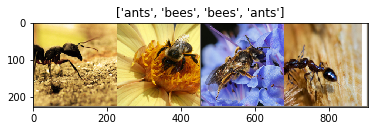

In [3]:
def imshow(inp, title=None):
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
#     plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(data_loaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

In [4]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()
    
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    
    for epoch in range(num_epochs):
        print("Epoch {}/{}".format(epoch, num_epochs - 1))
        print("-" * 10)
        
        for phase in ['train', 'val']:
            if phase == 'train':
                scheduler.step()
                model.train()
            else:
                model.eval()
                
            running_loss = 0.0
            running_corrects = 0
            
            for inputs, labels in data_loaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)
                
                optimizer.zero_grad()
                
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)
                    
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                        
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
                
            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]
            
            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))
            
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
                
        print()
            
    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [5]:
import torch.nn.functional as F
from torch.autograd import Variable

def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(data_loaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(class_names[preds[j]]))
                cpu = inputs.cpu()
                cpu = torch.nn.Upsample(scale_factor=2, mode='nearest')(cpu)
                imshow(cpu.data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

In [6]:
model_ft = models.resnet18(pretrained=True)
num_ftrs = model_ft.fc.in_features
model_ft.fc = nn.Linear(num_ftrs, 2)

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

In [7]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler)

Epoch 0/24
----------
train Loss: 0.6721 Acc: 0.6475
val Loss: 0.2291 Acc: 0.9346

Epoch 1/24
----------
train Loss: 0.4280 Acc: 0.8320
val Loss: 0.3016 Acc: 0.8824

Epoch 2/24
----------
train Loss: 0.5203 Acc: 0.8033
val Loss: 0.2168 Acc: 0.9346

Epoch 3/24
----------
train Loss: 0.4163 Acc: 0.8156
val Loss: 0.1510 Acc: 0.9412

Epoch 4/24
----------
train Loss: 0.5267 Acc: 0.8279
val Loss: 0.1651 Acc: 0.9346

Epoch 5/24
----------
train Loss: 0.5875 Acc: 0.8074
val Loss: 0.3161 Acc: 0.8954

Epoch 6/24
----------
train Loss: 0.3855 Acc: 0.8607
val Loss: 0.2583 Acc: 0.8954

Epoch 7/24
----------
train Loss: 0.3059 Acc: 0.8811
val Loss: 0.2231 Acc: 0.9020

Epoch 8/24
----------
train Loss: 0.2955 Acc: 0.8689
val Loss: 0.1923 Acc: 0.9216

Epoch 9/24
----------
train Loss: 0.3709 Acc: 0.8402
val Loss: 0.2634 Acc: 0.8954

Epoch 10/24
----------
train Loss: 0.2669 Acc: 0.8811
val Loss: 0.1996 Acc: 0.9150

Epoch 11/24
----------
train Loss: 0.2676 Acc: 0.8770
val Loss: 0.2084 Acc: 0.9020

Ep

C:\Users\HwangInkiu\Anaconda3\envs\torch-lab\lib\site-packages\torch\nn\modules\upsampling.py:129: UserWarning: nn.Upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.{} is deprecated. Use nn.functional.interpolate instead.".format(self.name))


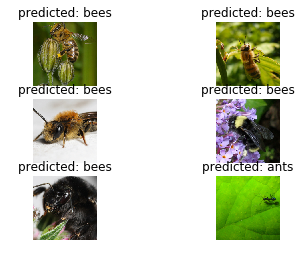

In [8]:
visualize_model(model_ft)

In [9]:
model_conv = torchvision.models.resnet18(pretrained=True)
for param in model_conv.parameters():
    param.requires_grad = False

num_ftrs = model_conv.fc.in_features
model_conv.fc = nn.Linear(num_ftrs, 2)

model_conv = model_conv.to(device)

criterion = nn.CrossEntropyLoss()

optimizer_conv = optim.SGD(model_conv.fc.parameters(), lr=0.001, momentum=0.9)

exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)

In [10]:
mode_conv = train_model(model_conv, criterion, optimizer_conv, exp_lr_scheduler, num_epochs=25)

Epoch 0/24
----------
train Loss: 0.6550 Acc: 0.6762
val Loss: 0.2796 Acc: 0.8889

Epoch 1/24
----------
train Loss: 0.6331 Acc: 0.7090
val Loss: 0.4250 Acc: 0.8235

Epoch 2/24
----------
train Loss: 0.4757 Acc: 0.7951
val Loss: 0.3632 Acc: 0.8431

Epoch 3/24
----------
train Loss: 0.8071 Acc: 0.6926
val Loss: 0.9675 Acc: 0.6928

Epoch 4/24
----------
train Loss: 0.3652 Acc: 0.8320
val Loss: 0.2190 Acc: 0.9281

Epoch 5/24
----------
train Loss: 0.4364 Acc: 0.8115
val Loss: 0.2240 Acc: 0.9477

Epoch 6/24
----------
train Loss: 0.3298 Acc: 0.8648
val Loss: 0.1952 Acc: 0.9281

Epoch 7/24
----------
train Loss: 0.4923 Acc: 0.7951
val Loss: 0.1928 Acc: 0.9477

Epoch 8/24
----------
train Loss: 0.4061 Acc: 0.8279
val Loss: 0.1973 Acc: 0.9542

Epoch 9/24
----------
train Loss: 0.3482 Acc: 0.8730
val Loss: 0.1763 Acc: 0.9542

Epoch 10/24
----------
train Loss: 0.3090 Acc: 0.8648
val Loss: 0.2146 Acc: 0.9281

Epoch 11/24
----------
train Loss: 0.3658 Acc: 0.8648
val Loss: 0.2086 Acc: 0.9346

Ep

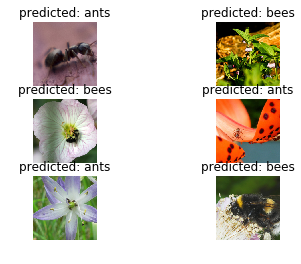

In [11]:
visualize_model(model_conv)

plt.ioff()
plt.show()